### <strong>第二次淺度機器學習作業：SVD與影像特徵實驗</strong>
學號：711233109

姓名：張子恩 
<hr>

 <font color=steelblue>**作業目標**</font>
  <br>
  
本次作業透過PCA與SVD分解原理來達到影像壓縮的效果，以及討論解鎖與鑰匙的概念。

<hr>


<hr>

 <font color=steelblue>**先備知識**</font>
  <br>
  
本次作業圖片的品質好壞使用峰值訊噪比（Peak signal-to-noise ratio，常縮寫為PSNR）來比較，其公式在自定義函數區域能找到。圖像與影像壓縮中典型的峰值訊噪比值在 30dB 到 50dB 之間，愈高愈好。<br>
其數值代表意義：<br>
- PSNR接近 50dB ，代表壓縮後的圖像僅有些許非常小的誤差。<br>
- PSNR大於 30dB ，人眼很難察覺壓縮後和原始影像的差異。<br>
- SNR介於 20dB 到 30dB 之間，人眼就可以察覺出圖像的差異。<br>
- PSNR介於 10dB 到 20dB 之間，人眼還是可以用肉眼看出這個圖像原始的結構，且直觀上會判斷兩張圖像不存在很大的差異。<br>
- PSNR低於 10dB，人類很難用肉眼去判斷兩個圖像是否為相同，一個圖像是否為另一個圖像的壓縮結果。<br>

<hr>


本次作業中，使用了許多自定義函數，為了排版整潔，故將他們整理好先放在最前面（自定義函數區域），並以註解解釋。

In [74]:
import numpy as np
from numpy.linalg import svd 
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
from numpy.linalg import eig
import sys
from skimage.metrics import peak_signal_noise_ratio
from matplotlib.ticker import PercentFormatter
import pandas as pd
import scipy.io

def PSNR(img1,img2,max):
    """
    max為像素最大值，因圖的像素有可能標準化所以需要先觀察，
    max值可能為1或255
    """
    mse = np.mean((img1-img2)**2)
    PSNR = 10*np.log10(max**2/((mse)))
    return(PSNR)


def seg_to_re(A,n,r):
    """
    n <- 以幾乘幾來分割
    r <- rank q
    """
    s,t= A.shape
    segment = np.zeros((n*n,int(s*t/(n*n))))
    count =0 
    for i in range(0,s,n):
        for j in range(0,s,n):
            segment[:,count]=A[i:i+n,j:j+n].reshape(n*n)
            count+=1
    U, E, VT = svd(segment,full_matrices= False)
    re = np.zeros((s,t))
    Xq = U[:,:r]@U[:,:r].T@segment
    c=0
    for i in range(0,s,n):
        for j in range(0,s,n):
            re[i:i+n,j:j+n]=Xq[:,c].reshape((n,n))
            c+=1
    return(re)

ratio= lambda  q ,r : (512**2)/((int((512/q)**2)+q**2+1)*r)

def montage(A,m,n):
    sz = np.sqrt(A.shape[0]).astype(int)
    M = np.zeros((m*sz,n*sz))
    for i in range(m):
        for j in range(n):
            M[i*sz:(i+1)*sz,j*sz:(j+1)*(sz)]=A[:,i*n+j].reshape(sz,sz)
    return(M)

def choice(A,b,target,n):
    """
    A <- X
    b <- y
    target <- 選取數字
    n <- 抽幾次
    """
    choice=np.random.choice(A[:,b==target].shape[1],replace=False,size=n)
    indices = np.where(b == target)[0]
    Digit = A[:,indices[choice]]
    return(Digit)


#### ***Leason 6 習題 1***
將一張圖像 X 利用 SVD 的 “Rank q approximation”，能達到壓縮的目的並保持圖像的品質。比較下列幾種對於圖像矩陣 X 的重組安排，並進行 “Rank q approximation”，在同樣的壓縮比之下，觀察還原後的圖像品質哪個最好？能說出理由嗎？

1.X 不變<b>

2.將 X 以 8\times 8 小圖（patch）進行切割，再將每個小圖拉成 64 X 1 的向量，最後重組這些向量並排成新的 64 X N 矩陣。<b>

3.同上，小圖大小為  16 X 16/per patch。<b>

4.同上，但分割成  32 X 32/per patch。<b>

5.其他天馬行空的想法。可行不可行？試試看便知道~ <b>



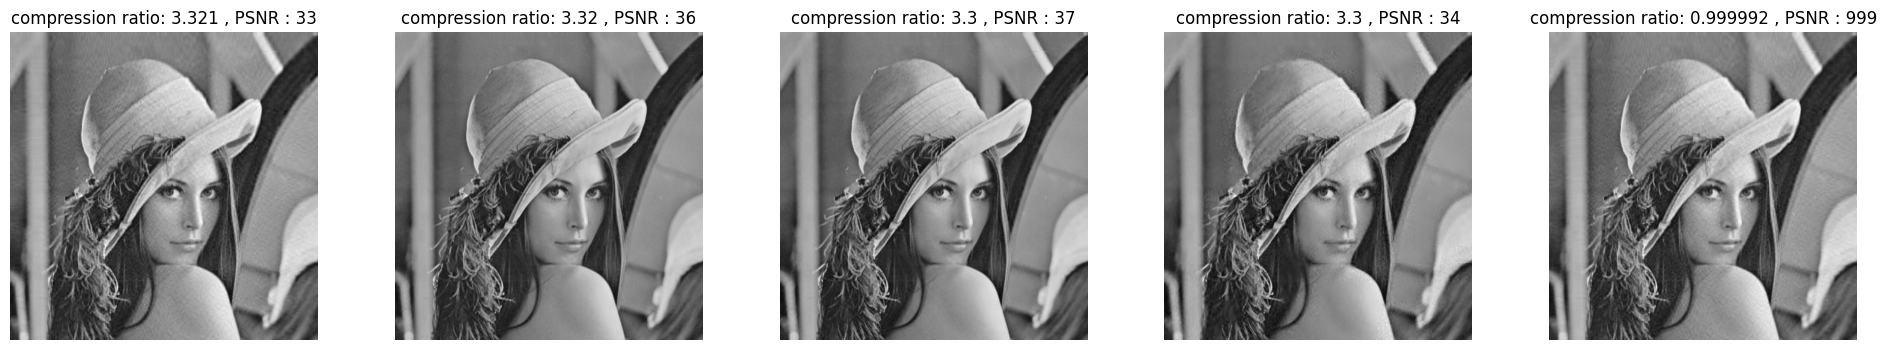

In [75]:

imgfile = '/Users/peterppp/vscode/淺度機器學習/hw2/lenna.png'# 512x512x3 
X = mpimg.imread(imgfile)
if len(X.shape) > 2:
    X = np.mean(X, axis=2) # convert RGB to grayscale

q = [8,16,32]
sigma = [19,62,62]
r= 77
N, p = X.shape
U, E, VT = svd(X,full_matrices= False)
Xq = U[:,:r]@U[:,:r].T@X


fig,ax = plt.subplots(1,5,figsize=(24,4))



ax[0].imshow(Xq,cmap="gray")
ax[0].axis("off")
ax[0].set_title("compression ratio: {} , PSNR : {}".format(round(512**2/(77*1025),3),int(PSNR(X,Xq,1))))



for i,n in enumerate(q):
    re = seg_to_re(X,n,sigma[i])
    ax[i+1].imshow(re,cmap="grey")
    ax[i+1].set_title("compression ratio: {} , PSNR : {}".format(round(ratio(n,sigma[i]),2),int(PSNR(X,re,1))))
    ax[i+1].axis("off")
    ax[i+1].set_xlabel("{}X{}".format(2**(i+4),2**(i+4)))
X4 = X.reshape((1,512*512))
U, E, VT = svd(X4,full_matrices= False)
Xc = U[:,:1]@U[:,:1].T@X4
Xc = Xc.reshape((512,512))
ax[4].imshow(Xq,cmap="grey")
ax[4].set_title("compression ratio: {} , PSNR : {}".format(round(512**2/((512**2)+2),6),999))
ax[4].axis("off")
plt.show()




#### **討論**
從左而右分別為對應題目中所問的五個小題，將壓縮比固定3.3左右，其主成份分別取77、19、62、62下壓縮的，可以發現在當X在以8X8進行切割下(第二張)，PSNR最高，為36，最低為使用原圖壓縮（第一張），為33。其實以16X16（第三張）和32X32（第四張）切割下，給定同一個q，其壓縮比竟然是一樣但其壓縮後品質略微不同，其算法可以在一開始的自定義函數(ratio)找到解答。這裡值得討論的是，到底該怎麼切割以及應該選取多少主成份才能使壓縮比和PSNR最好，下面將為你解答。  
第五張為，先拉成1X262144在進行svd分解，並且取前一個主成份而已，其壓縮比就小於1且接近1，且PSNR會接近無限，原因為其壓縮過後的圖與原圖一樣使得公式分母為0，如果在取多一點主成份來壓縮，其壓縮比會來得越小，代表越壓縮越“大”，所以此方法不是個好方法。

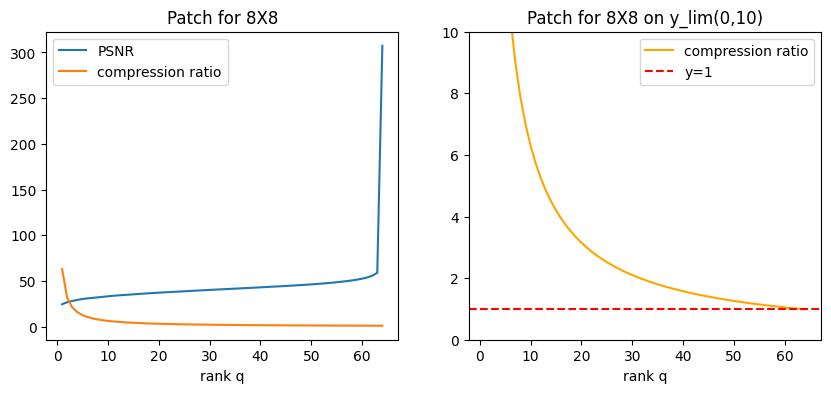

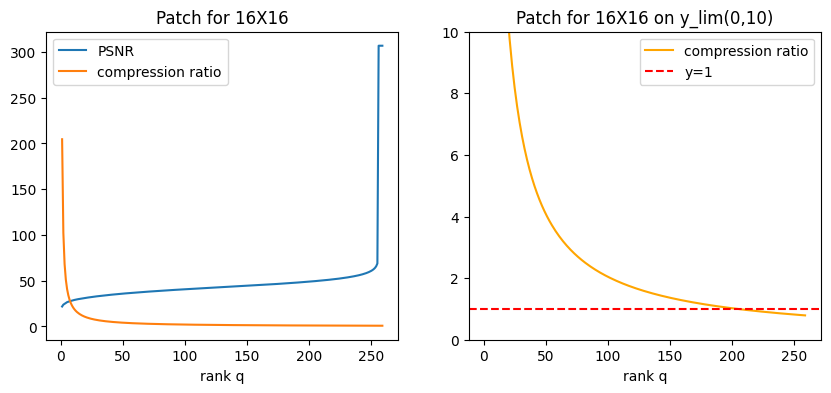

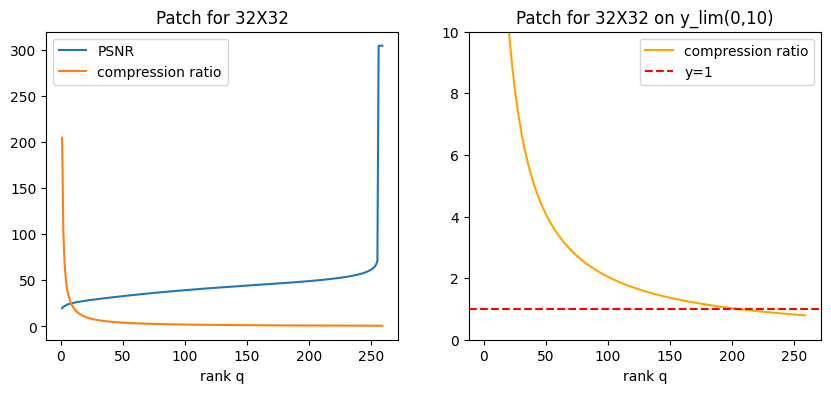

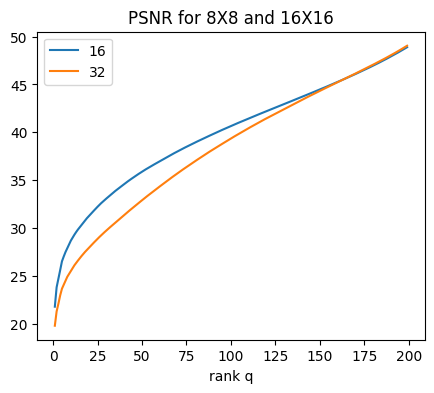

In [76]:
# q為要分割的邊長數 r為rank r output為 ratio
#goal 找尋最好的rank q apporox 和 ratio 在各個切割下
#8*8
ratio1 =[]
PSNR1 =[]
q = 65
for i in range(1,q) :
    Xq=seg_to_re(X,8,i)
    PSNR1.append(PSNR(Xq,X,1))
    ratio1.append(ratio(8,i))
rank_q = np.arange(1,q)
fig,ax = plt.subplots(1,2,figsize = (10,4))
ax[0].plot(rank_q,PSNR1,label="PSNR")
ax[0].set_xlabel("rank q")
ax[0].plot(rank_q,ratio1,label = "compression ratio")
ax[0].legend()
ax[0].set_title("Patch for 8X8")
ax[1].plot(rank_q,ratio1,label = "compression ratio",color = "orange")
ax[1].set_ylim(0,10)
ax[1].set_xlabel("rank q")
ax[1].set_title("Patch for 8X8 on y_lim(0,10)")
ax[1].axhline(y=1, color='r', linestyle='--', label='y=1')
ax[1].legend()
plt.show()
#16*16
ratio1 =[]
PSNR1 =[]
q = 260
for i in range(1,q) :
    Xq=seg_to_re(X,16,i)
    PSNR1.append(PSNR(Xq,X,1))
    ratio1.append(ratio(16,i))
rank_q = np.arange(1,q)
fig,ax = plt.subplots(1,2,figsize = (10,4))
ax[0].plot(rank_q,PSNR1,label="PSNR")
ax[0].set_xlabel("rank q")
ax[0].plot(rank_q,ratio1,label = "compression ratio")
ax[0].legend()
ax[0].set_title("Patch for 16X16")
ax[1].plot(rank_q,ratio1,label = "compression ratio",color = "orange")
ax[1].set_ylim(0,10)
ax[1].set_xlabel("rank q")
ax[1].set_title("Patch for 16X16 on y_lim(0,10)")
ax[1].axhline(y=1, color='r', linestyle='--', label='y=1')
ax[1].legend()
plt.show()
#32*32
ratio1 =[]
PSNR1 =[]
q = 260
for i in range(1,q) :
    Xq=seg_to_re(X,32,i)
    PSNR1.append(PSNR(Xq,X,1))
    ratio1.append(ratio(32,i))
rank_q = np.arange(1,q)
fig,ax = plt.subplots(1,2,figsize = (10,4))
ax[0].plot(rank_q,PSNR1,label="PSNR")
ax[0].set_xlabel("rank q")
ax[0].plot(rank_q,ratio1,label = "compression ratio")
ax[0].legend()
ax[0].set_title("Patch for 32X32")
ax[1].plot(rank_q,ratio1,label = "compression ratio",color = "orange")
ax[1].set_ylim(0,10)
ax[1].set_xlabel("rank q")
ax[1].set_title("Patch for 32X32 on y_lim(0,10)")
ax[1].axhline(y=1, color='r', linestyle='--', label='y=1')
ax[1].legend()
plt.show()



psnr16 =[]
psnr32 =[]
for i in range(1,200) :
    Xq16=seg_to_re(X,16,i)
    psnr16.append(PSNR(Xq16,X,1))
    Xq32=seg_to_re(X,32,i)
    psnr32.append(PSNR(Xq32,X,1))
rank_q = np.arange(1,200)
plt.figure(figsize=(5,4))
plt.plot(rank_q,psnr16,label = "16")
plt.plot(rank_q,psnr32,label = "32")
plt.title("PSNR for 8X8 and 16X16")
plt.xlabel("rank q")
plt.legend()
# plt.ylim(20,50)
plt.show()




    
    





#### **討論**
第一張圖為在8X8切割下，選取不同的主成份（q）下的PSNR值和壓縮比，因q在60後面雖然PSNR非常高，單其壓縮比反而是小於1，故不討論，第一張圖（左）可以看到q在前60下，PSNR介於25~50之間，為了更清楚壓縮比情況，繪製了第一張圖（右），能發現壓縮比在q接近60後漸漸小於1，為了達到記憶體壓縮，選取的主成份(q)不能大於60。  
第二張圖為在16X16切割下，選取不同的主成份（q）下的PSNR值和壓縮比，因q在250後面雖然PSNR非常高，單其壓縮比反而是小於1，故不討論，第一張圖（左）可以看到q在前250下，PSNR介於25~50之間，為了更清楚壓縮比繪製了第二張圖（右），能發現壓縮比在q接近200後漸漸小於1，為了達到記憶體壓縮，選取的主成份(q)不能大於200。  
第三張圖為在32X32切割下，選取不同的主成份（q）下的PSNR值和壓縮比，因q在250後面雖然PSNR非常高，單其壓縮比反而是小於1，故不討論，第一張圖（左）可以看到q在前250下，PSNR介於25~50之間，為了更清楚壓縮比繪製了第二張圖（右），能發現壓縮比在q接近200後漸漸小於1，為了達到記憶體壓縮，選取的主成份(q)不能大於200。   
因16X16和32X32在不同q下其壓縮比會一樣，我們想要知道在q選取200以內哪個PSNR會比較高，第四張為16X16和32X32在q在兩百以內的PSNR值，可以發現q在150以內PSNR以16X16分割方法會來得比32X32還高，故16X16會來得比32X32還好。  
從以上圖得知，在不同方法切割下，只要能達到記憶體壓縮，要取前幾個主成分來壓縮是沒有標準答案的，取決於你想要的壓縮比和PSNR為多少。


#### ***Leason 6 習題 2***  
處理大量影像前，有必要觀看影像圖，以確定能掌握將要處理的影像及其資料型態。以 70000 張手寫圖像為例，每個數字約 7000 字，需要寫一段程式碼來觀察這些手寫數字的影像與品質，且每次執行都能隨機觀看到不同的影像，如下圖左（共兩排含 0~9 的數字各 50 個）與圖右的影像是兩次執行的結果。

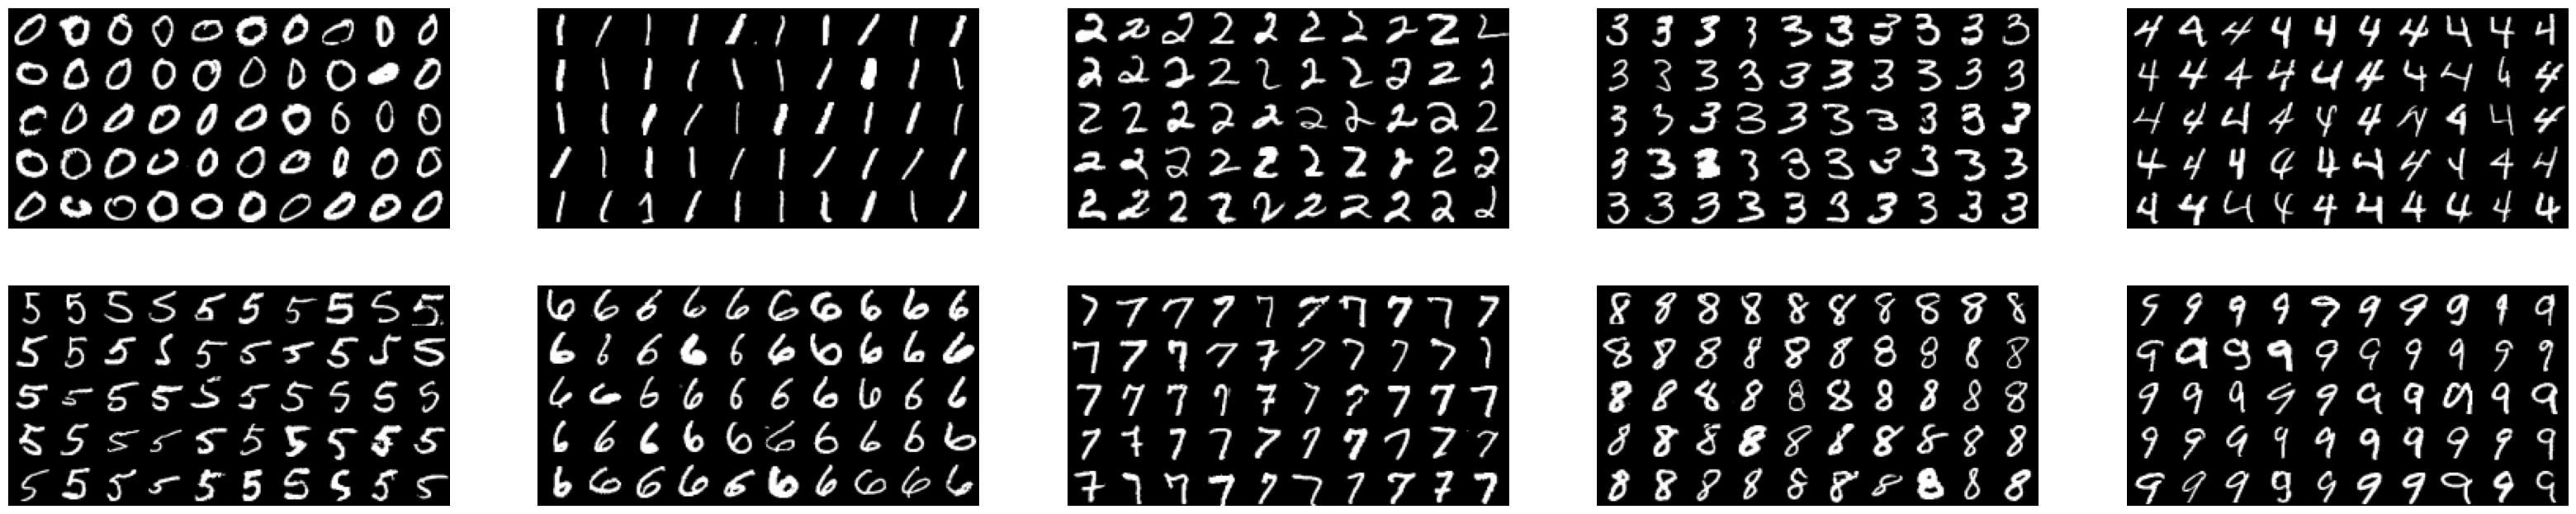

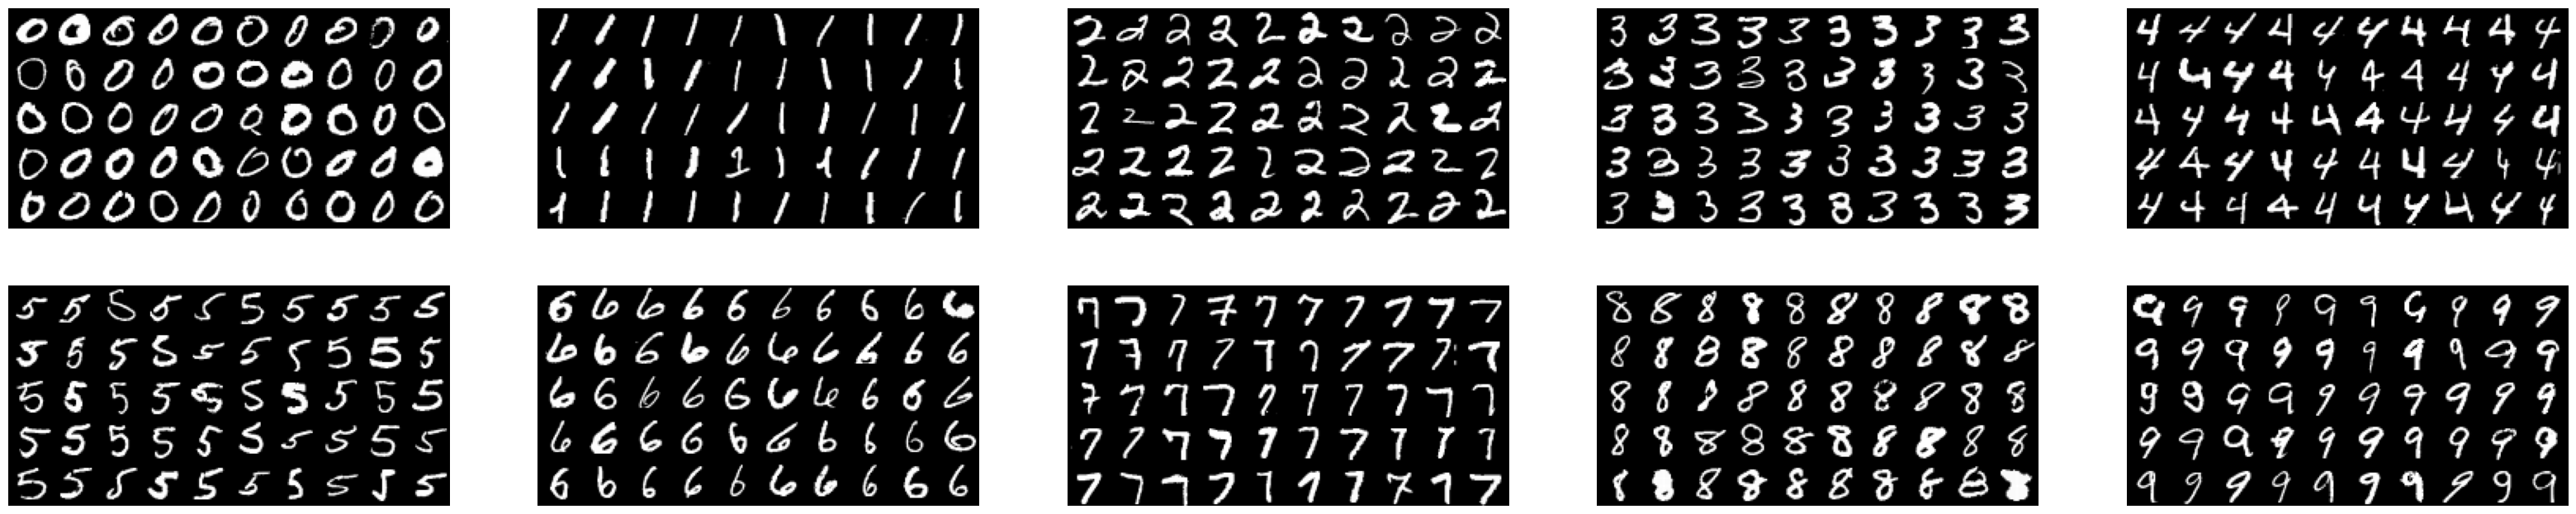

In [77]:
import pickle
# 定义文件路径
pickle_file = '/Users/peterppp/vscode/淺度機器學習/hw2/mnist_784.pkl'

# # 如果要保存数据到 pickle 文件
# with open(pickle_file, 'wb') as f:
#     pickle.dump((X, y), f)

# 如果要从 pickle 文件加载数据
with open(pickle_file, 'rb') as f:
    data = pickle.load(f)

X,y=data
X = np.array(X).T
X = X.astype("float")
y=np.array(y).astype("int")


c = 0 
fig,ax = plt.subplots(2,5,figsize=(40,8))
for i in range(2):
    for j in range(5):
        Digit = choice(X,y,c,50)
        M = montage(Digit,5,10)
        ax[i][j].imshow(M,cmap="gray", extent=(0 ,120, 0, 60))
        ax[i][j].axis("off")
        c +=1
plt.show()

c = 0 
fig,ax = plt.subplots(2,5,figsize=(40,8))
for i in range(2):
    for j in range(5):
        Digit = choice(X,y,c,50)
        M = montage(Digit,5,10)
        ax[i][j].imshow(M,cmap="gray", extent=(0 ,120, 0, 60))
        ax[i][j].axis("off")
        c +=1
plt.show()




#### **討論**

上面是0到9各隨機抽取50次的圖，為了證明是隨機的，故列印兩次出來，其隨機抽取程式碼（choice），整理在自定義函數區域。

#### ***Leason 6 習題 3***  
每張大小 28×28 的手寫數字圖像 70000 張，不經壓縮前的儲存空間為 54.88 M Bytes。若進行 SVD 的 “Rank q approximation”，則壓縮倍數由 q 決定。寫一支程式，當調整 q 值時，可以算出壓縮的倍數，並同時顯示原圖與壓縮後還原的圖各 100 張做為比較（任選 100 張）。另外 q 的選擇可以根據 $\sigma_1, \sigma_2, \cdots,  \sigma_r $的「能量配置」來決定，或說決定 q 之後，可以計算所採用的主成分的能量佔比，本題也可以順便列印出這個佔比。

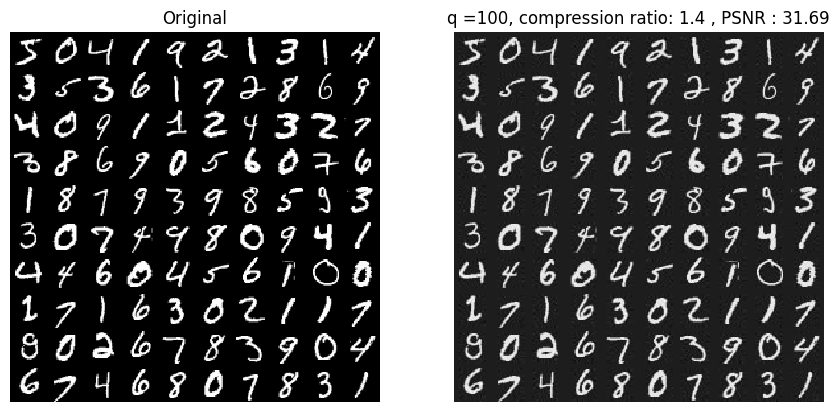

In [78]:
f = lambda r: (280*280)/(r*(561)) 
g = lambda r :(28*28)/(r*(57))
m,n=10,10
M = montage(X,m,n)
fig,ax = plt.subplots(1,2,figsize=(10.5,21))
# plt.subplot(1,2,1)
ax[0].imshow(M,cmap="gray",interpolation="nearest")
ax[0].axis("off")
ax[0].set_title("Original")



U, E, VT = svd(M,full_matrices= False)


r= 100 
f = lambda r: (280*280)/(r*(561)) #rank q 
Xq = U[:,0:r]@U[:,0:r].T@M
# plt.subplot(1,2,2)
ax[1].imshow(Xq,cmap="gray",interpolation="nearest")
ax[1].axis("off")
ax[1].set_title("q ={}, compression ratio: {} , PSNR : {}".format(r,round(f(r),2),round(PSNR(M,Xq,255),2)))
plt.show()










#### **討論**  
其壓縮有兩中方法，第一種是先將100個數字組成10X10得圖片後再進行壓縮，另一種是先將每個數字壓縮再合併成10X10的圖片，這裡使用第一種，理由等等會說明，上圖中左圖為原圖，右圖為選取在前100個主成份，其壓縮比為1.4，PSNR為31.69，下面將使用Pareto Plot來觀察其各個主成份的佔比。

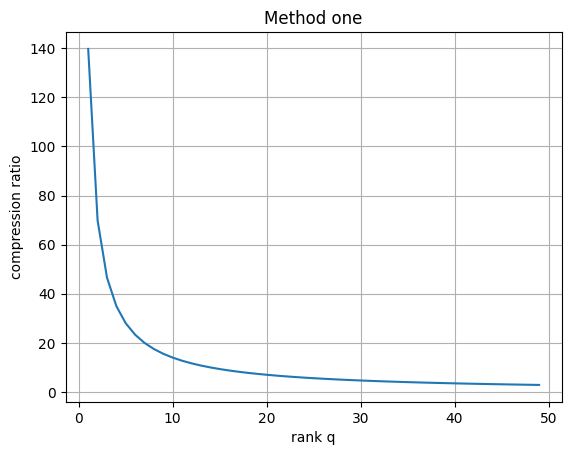

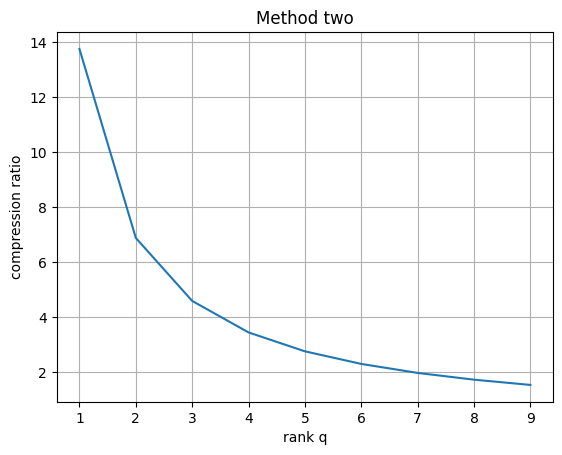

In [79]:
f = lambda r: (280*280)/(r*(561)) 
g = lambda r :(28*28)/(r*(57))
r= np.arange(1,10)
R = np.arange(1,50)
#使用280*280在壓縮
plt.figure()
plt.plot(R,f(R))
plt.xlabel("rank q")
plt.ylabel('compression ratio')
plt.title("Method one")
plt.grid()
plt.show()
#使用原圖28*28壓縮後再合併成280*280
plt.figure()
plt.plot(r,g(r))
plt.xlabel("rank q")
plt.ylabel('compression ratio')
plt.ylabel('compression ratio')
plt.title("Method two")
plt.grid()
plt.show()

#### **討論**  
第一張圖和第二張分別為將100個數字組成10X10的圖片後再進行壓縮和先將每個數字壓縮再合併成10X10的圖片，其選取的q和壓縮比關係圖，可以清楚看到第二種方法其主成份只有九個，且其壓縮比遠小於第一種方法，故這裡選取第一種方法來進行壓縮。


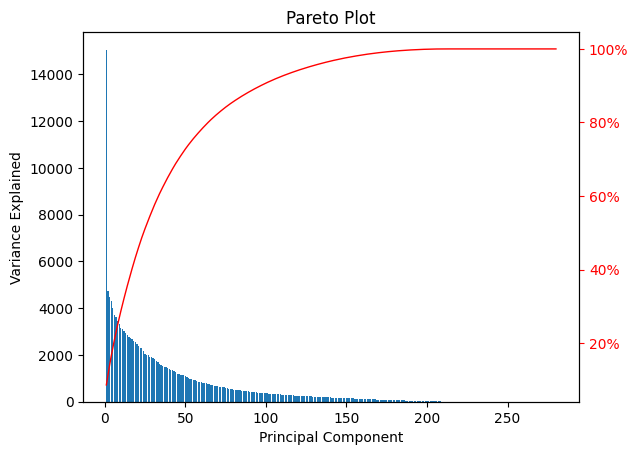

In [80]:

fig, ax = plt.subplots()
eigvals = E[:280]
x = np.arange(1, 1+len(eigvals))
ax.bar(x, eigvals)
ax2 = ax.twinx()
ax2.plot(x, eigvals.cumsum()/eigvals.sum()*100, color="red", lw=1)
ax2.tick_params(axis="y", colors="red")
ax2.yaxis.set_major_formatter(PercentFormatter())
ax.set_xlabel('Principal Component')
ax.set_ylabel('Variance Explained')
ax.set_title("Pareto Plot")
plt.show()





#### **討論**  
上圖為總共280個主成份的Pareto plot，第一個主成份分就佔整個主成份變異量的三成多其解釋能力也遠遠超過其他主成份，前五十個主成份就高達七成。

#### **Leason 7 習題 1**
有 5 張經過加密的影像圖，其加密的方式採 Yale Faces 38 人 2410 張人臉圖像矩陣 X 的 SVD，即 $X = U\Sigma V^T$，取 U 作為影像加密的工具，即假設向量 x 代表一張原圖影像，則 $U[:, 0:q]^T x$ 代表該影像的前 q 個主成分，以此作為加密影像。

1.請解密這五張圖。

/var/folders/w3/05yx52ld5_zdg1rr63rr_rh00000gn/T/ipykernel_10454/3009797293.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  m = int(face_data['m'])#168
/var/folders/w3/05yx52ld5_zdg1rr63rr_rh00000gn/T/ipykernel_10454/3009797293.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  n = int(face_data['n'])#192
/var/folders/w3/05yx52ld5_zdg1rr63rr_rh00000gn/T/ipykernel_10454/3009797293.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  n_persons= int(face_data['per

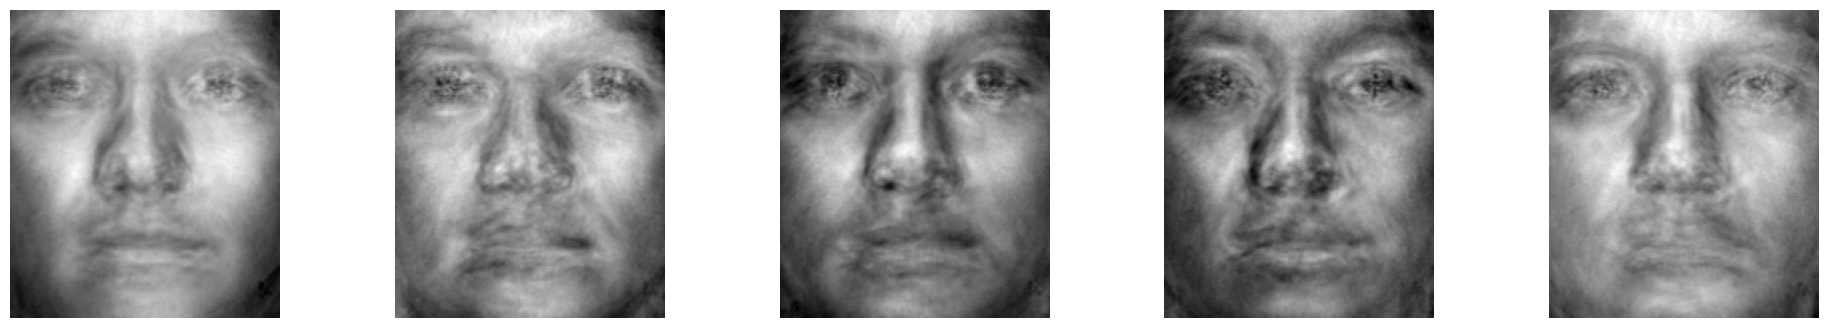

In [81]:

csv_file= pd.read_csv('/Users/peterppp/vscode/淺度機器學習/hw2/五張加密的影像_2024.csv')
face_data = scipy.io.loadmat("/Users/peterppp/vscode/淺度機器學習/hw2/allFaces.mat")
X = face_data["faces"]
y = np.ndarray.flatten(face_data["nfaces"])
m = int(face_data['m'])#168
n = int(face_data['n'])#192
n_persons= int(face_data['person'])#38

X1= X-np.mean(X)
U, E, VT = svd(X1,full_matrices= False)
u=(U)[:,:2000]
data = csv_file.values
fig,ax = plt.subplots(1,5,figsize=(24,4))
for i in range(5):
    xq = u@data[:,i]
    ax[i].imshow(xq.reshape((168,192)).T,cmap="gray")
    ax[i].axis("off")
plt.show()




#### **討論**
成功解密這五張圖，皆能看出人臉的輪廓，但說不上清晰。

#### **Leason 7 習題 1**
自行找 5 張照片（大小必須同 Yale Faces 的 192×168 或自行 Resize），含人臉、水果、風景 … 等進行加密後（q 自選），再解密，觀察這些解密後的影像的效果，是否人臉的表現比較好？其他非人臉影像，如風景影像，能透過由人臉建構的特徵 U 加密嗎？（即解密後能否看到原圖模樣？）

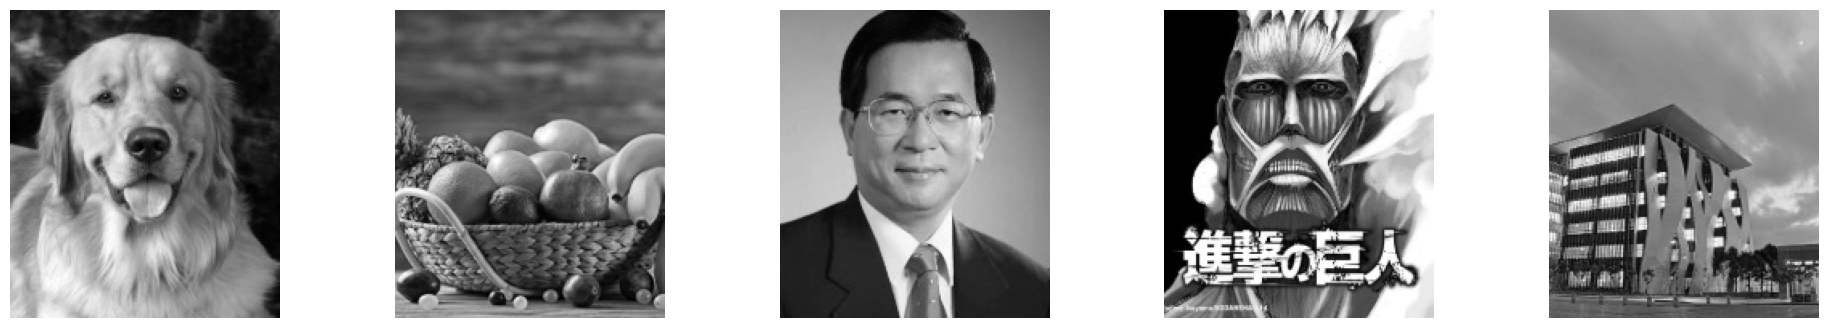

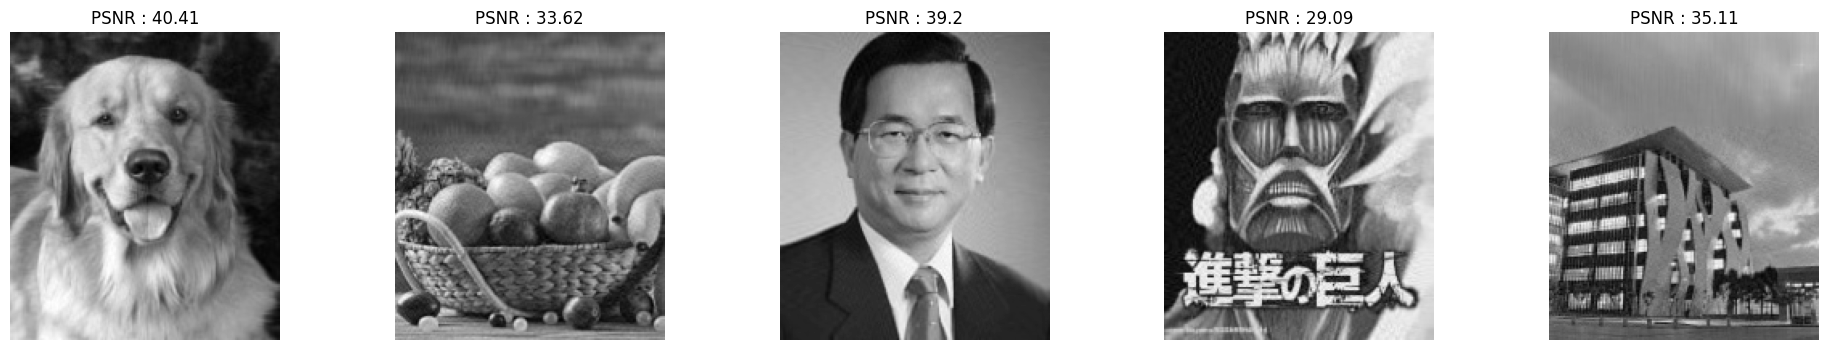

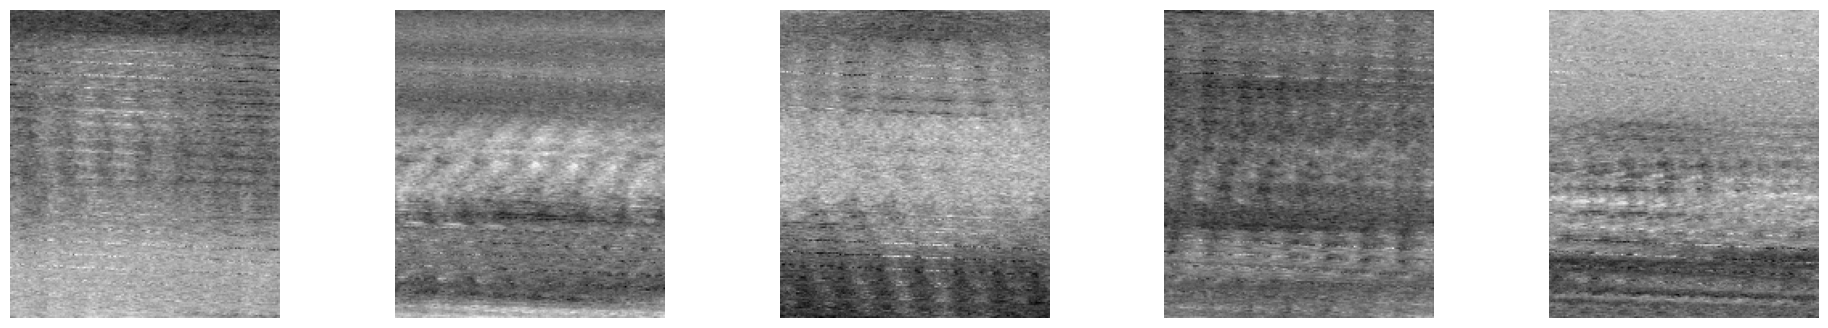

In [82]:

pictures = [
    '/Users/peterppp/vscode/淺度機器學習/hw2/170261261317046_P26487974-2.jpg',
    '/Users/peterppp/vscode/淺度機器學習/hw2/2022-04-01_164326-5.jpg',
    '/Users/peterppp/vscode/淺度機器學習/hw2/總統陳水扁先生玉照_(國民大會實錄)-3.jpg',
    '/Users/peterppp/vscode/淺度機器學習/hw2/a07cdb7a24ebb4dfe8e27f9dd3167a3d-3.jpg',
    '/Users/peterppp/vscode/淺度機器學習/hw2/1920x1080_1df1f888-881a-4399-b1c8-630a14c245b5-4.jpg'
]

fig, ax = plt.subplots(1, 5, figsize=(24, 4))
for i in range(5):
    
    x = mpimg.imread(pictures[i])
    
    if len(x.shape) > 2:
        x = np.mean(x, axis=2) 
    ax[i].imshow(x,cmap="gray")
    ax[i].axis("off")
plt.show()

fig,ax = plt.subplots(1,5,figsize=(24,4))
for i in range(5):
    
    x = mpimg.imread(pictures[i])
    if len(x.shape) > 2:
        x = np.mean(x, axis=2) 
    UU, E, VT = svd(x,full_matrices= False)
    u = UU[:,:50]
    new = u@u.T@x
    ax[i].imshow(new.reshape((192,168)),cmap="gray")
    ax[i].set_title("PSNR : {}".format(round(PSNR(x,new,256),2)))
    ax[i].axis("off")
plt.show()




u=(U)[:,:2000]
fig,ax = plt.subplots(1,5,figsize=(24,4))
for i in range(5):
    
    x = mpimg.imread(pictures[i])
    if len(x.shape) > 2:
        x = np.mean(x, axis=2) 
    x = np.ndarray.flatten(x)
    new = u@u.T@x
    ax[i].imshow(new.reshape((192,168)),cmap="gray")
    ax[i].axis("off")
plt.show()





#### **討論**
第一排分別為狗、水果、人物、動漫（略像人的圖片）以及台北大學圖書館的原圖，第二排為取前50主成份所組成的U進行加密在解密，其壓縮過後，PSNR都有良好的表現，用肉眼也能清楚看到與原圖差不多，第三排為拿上題的U進行解密在加密，
可以看到解密在加密後的圖像完全看不清楚，頂多第三張可以稍微看到人的輪廓，故使用上題的U來加密不太合適。